In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout, Masking

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import matplotlib as mpl 
import os 
import sys 
import time

import matplotlib.pyplot as plt

In [2]:

import ast
 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
import warnings
warnings.filterwarnings('ignore')

In [3]:
eICUerd_1st48hrs_st123_CleanedApacheResults = pd.read_csv('../data/First48Hrs_NestedDF_afterMICEforest_MergedWith_Cleaned_ApacheResultsSheet_Ver3.csv').reset_index(drop = True)
# eICUerd_1st48hrs_st123_CleanedApacheResults['predictediculos'] = eICUerd_1st48hrs_st123_CleanedApacheResults['predictediculos'].astype('float64')

In [4]:
eICUerd_1st48hrs_st123_CleanedApacheResults_ExitedHospitalAlive = eICUerd_1st48hrs_st123_CleanedApacheResults.loc[eICUerd_1st48hrs_st123_CleanedApacheResults['actualhospitalmortality'] == 0].reset_index(drop = True)
eICUerd_1st48hrs_st123_CleanedApacheResults_ExitedHospitalAlive 

,PatientUnitStay_ID,num_measurements,monitoring_start,monitoring_end,monitoring_duration_inMinutes_minutes,avg_measurement_interval,avg_temperature,avg_heart_rate,avg_saO2,avg_systolic_bp,...,dischargelocation,visitnumber,amilocation,day1meds,day1verbal-gcs,day1motor-gcs,day1eyes-gcs,day1pao2,day1fio2,PredictedICUmortality_binary
0,143941,575,6,2876,2870,5.000000,37.043043,76.794783,98.300870,101.259130,...,4.0,1,NaN,False,5.0,6.0,4.0,186.0,50.0,False
1,161093,573,4,2879,2875,5.026224,37.115620,74.157068,97.200698,113.804538,...,4.0,1,NaN,False,5.0,6.0,4.0,NaN,NaN,False
2,177460,576,5,2880,2875,5.000000,37.157639,84.744792,96.095486,112.310764,...,8.0,2,6.0,False,5.0,6.0,4.0,NaN,NaN,False
3,227852,520,5,2880,2875,5.539499,37.846923,92.807692,95.276923,126.796154,...,4.0,1,2.0,False,5.0,6.0,4.0,NaN,NaN,False
4,1055516,327,106,1736,1630,5.000000,37.161315,93.681957,98.250765,114.779817,...,4.0,1,NaN,False,1.0,3.0,2.0,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,3352114,286,21,1446,1425,5.000000,37.250350,87.472028,98.328671,115.262238,...,8.0,1,NaN,False,5.0,6.0,4.0,NaN,NaN,False
923,3352178,301,15,1515,1500,5.000000,36.519269,82.428571,97.332226,118.073090,...,8.0,1,NaN,False,5.0,6.0,4.0,158.0,100.0,False
924,3352344,348,5,1740,1735,5.000000,37.364799,104.497126,98.537356,114.752874,...,8.0,1,NaN,False,5.0,6.0,4.0,318.0,100.0,False
925,3352620,429,26,2876,2850,6.658879,37.226107,90.668998,97.431235,160.184149,...,8.0,1,NaN,False,5.0,6.0,4.0,95.0,21.0,False


In [5]:
eICUerd_1st48hrs_st123_CleanedApacheResults_ExitedHospitalAlive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927 entries, 0 to 926
Data columns (total 99 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   PatientUnitStay_ID                         927 non-null    int64  
 1   num_measurements                           927 non-null    int64  
 2   monitoring_start                           927 non-null    int64  
 3   monitoring_end                             927 non-null    int64  
 4   monitoring_duration_inMinutes_minutes      927 non-null    int64  
 5   avg_measurement_interval                   927 non-null    float64
 6   avg_temperature                            927 non-null    float64
 7   avg_heart_rate                             927 non-null    float64
 8   avg_saO2                                   927 non-null    float64
 9   avg_systolic_bp                            927 non-null    float64
 10  avg_diastolic_bp          

In [6]:
def load_and_parse_csv(Data_Frame):
    """
    Load CSV file and parse the nested time series data.
    
    The time series columns contain string representations of lists that need
    to be converted back to actual Python lists for processing.
    """
    print("Loading CSV data frame / file...")
    df = Data_Frame
    
    # Define the time series columns we need to process
    time_series_columns = [
        'time_series_temperature', 'time_series_sao2', 'time_series_heartrate',
        'time_series_respiration', 'time_series_cvp', 'time_series_systolic_bp',
        'time_series_diastolic_bp', 'time_series_mean_bp', 'time_series_pa_systolic',
        'time_series_pa_diastolic', 'time_series_pa_mean', 'time_series_st1',
        'time_series_st2', 'time_series_st3', 'time_series_nested_gender',
        'time_series_oobintubday1_uponICUadmission',
        'time_series_activetx_uponICUadmission',
        'time_series_oobventday1_uponICUadmission',
        'time_series_motor_gcs_uponICUadmission',
        'time_series_verbal_gcs_uponICUadmission' #, 
      #  'time_series_apachescore_uponICUadmission'
    ]
    
    print(f"Dataset shape: {df.shape}")
    print(f"Time series columns to process: {len(time_series_columns)}")
    
    # Parse string representations of lists back to actual lists
    # This handles cases where the CSV stored lists as strings like "[1.2, 1.3, 1.4]"
    for col in time_series_columns:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    return df, time_series_columns

In [7]:
load_and_parse_csv_results = load_and_parse_csv(Data_Frame=eICUerd_1st48hrs_st123_CleanedApacheResults_ExitedHospitalAlive)

Loading CSV data frame / file...
Dataset shape: (927, 99)
Time series columns to process: 20


In [8]:
load_and_parse_csv_results

(     PatientUnitStay_ID  num_measurements  monitoring_start  monitoring_end  \
 0                143941               575                 6            2876   
 1                161093               573                 4            2879   
 2                177460               576                 5            2880   
 3                227852               520                 5            2880   
 4               1055516               327               106            1736   
 ..                  ...               ...               ...             ...   
 922             3352114               286                21            1446   
 923             3352178               301                15            1515   
 924             3352344               348                 5            1740   
 925             3352620               429                26            2876   
 926             3352878               571                26            2876   
 
      monitoring_duration_inMinutes_mi

In [9]:

TimeSeries_Features = ['time_series_temperature',
                        'time_series_sao2',
                        'time_series_heartrate',
                        'time_series_respiration',
                        'time_series_cvp',
                        'time_series_systolic_bp',
                        'time_series_diastolic_bp',
                        'time_series_mean_bp',
                        'time_series_pa_systolic',
                        'time_series_pa_diastolic',
                        'time_series_pa_mean',
                        'time_series_st1',
                        'time_series_st2',
                        'time_series_st3', 
                        'time_series_nested_gender',
                        'time_series_oobintubday1_uponICUadmission',
                        'time_series_activetx_uponICUadmission',
                        'time_series_oobventday1_uponICUadmission',
                        'time_series_motor_gcs_uponICUadmission',
                        'time_series_verbal_gcs_uponICUadmission' #,
                #        'time_series_apachescore_uponICUadmission'
                        ]



In [10]:
def pad_time_series_data(df, time_series_columns, padding_value=-999999):
    """
    Pad all time series to have the same length using a special padding value.
    
    We use a distinctive padding value (-999999) that will be masked out during training.
    This ensures all sequences have the same length while preserving the original
    temporal structure of each patient's data.
    """
    print("Padding time series data...")
    
    # Find the maximum length across all time series and all patients
    max_length = 0
    for col in time_series_columns:
        if col in df.columns:
            # Get the maximum length in this column across all patients
            col_max_length = df[col].apply(len).max()
            max_length = max(max_length, col_max_length)
    
    print(f"Maximum time series length found: {max_length}")
    
    # Pad each time series column to the maximum length
    for col in time_series_columns:
        if col in df.columns:
            # Pad sequences to max_length using our special padding value
            df[col] = df[col].apply(
                lambda x: x + [padding_value] * (max_length - len(x))
            )
    
    return df, max_length


In [11]:
pad_time_series_data_results = pad_time_series_data(df=load_and_parse_csv_results[0], time_series_columns=TimeSeries_Features) # or time_series_columns = TimeSeries_Features)


Padding time series data...
Maximum time series length found: 664


In [12]:
pad_time_series_data_results

(     PatientUnitStay_ID  num_measurements  monitoring_start  monitoring_end  \
 0                143941               575                 6            2876   
 1                161093               573                 4            2879   
 2                177460               576                 5            2880   
 3                227852               520                 5            2880   
 4               1055516               327               106            1736   
 ..                  ...               ...               ...             ...   
 922             3352114               286                21            1446   
 923             3352178               301                15            1515   
 924             3352344               348                 5            1740   
 925             3352620               429                26            2876   
 926             3352878               571                26            2876   
 
      monitoring_duration_inMinutes_mi

def prepare_lstm_data(df, time_series_columns, target_column=['actualiculos']):
    """
    Convert the padded time series data into the 3D format required by LSTM.
    
    LSTM expects input in shape (ICU Stays, Measurements across the same time steps, Features) where:
    - rows / ICU stays: number of patient visits
    - # of measurements across time steps: length of time series (padded to be consistent)
    - features: number of different measurements (14 vital signs)
    """
    print("Preparing data for LSTM...")
    
    # Create the 3D array for LSTM input
    # Shape will be (n_patient_visits, max_timesteps, n_features)
    n_patient_visits = len(df)
    max_timesteps = len(df[time_series_columns[0]].iloc[0])  # All should be same length after padding
    n_features = len(time_series_columns)
    
    global X, y 
    X = np.zeros((n_patient_visits, max_timesteps, n_features))
    
    # Fill the 3D array with time series data
    for i, (_, row) in enumerate(df.iterrows()):
        for j, col in enumerate(time_series_columns):
            if col in df.columns:
                X[i, :, j] = row[col]
    
    # Extract target variable (mortality outcome)
    y = df[target_column].values
    
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    # print(f"Target distribution: {np.bincount(y)}")
    
     
    return X, y

prepare_lstm_data_results = prepare_lstm_data(df=load_and_parse_csv_results[0], time_series_columns=load_and_parse_csv_results[1], target_column=['actualiculos']) # or time_series_columns = TimeSeries_Features)


In [13]:
df=load_and_parse_csv_results[0]
time_series_columns=load_and_parse_csv_results[1]
target_column=['actualiculos']

In [14]:
n_patients = len(df)
max_timesteps = len(df[time_series_columns[0]].iloc[0])  # All should be same length after padding
n_features = len(time_series_columns)

# global X, y 
X = np.zeros((n_patients, max_timesteps, n_features))

# Fill the 3D array with time series data
for i, (_, row) in enumerate(df.iterrows()):
    for j, col in enumerate(time_series_columns):
        if col in df.columns:
            X[i, :, j] = row[col]

# Extract target variable (mortality outcome)
y = df[target_column].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
# print(f"Target distribution: {np.bincount(y)}")



X shape: (927, 664, 20)
y shape: (927, 1)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state = 443)

In [16]:
X_train.shape

(741, 664, 20)

In [17]:
y_train.shape

(741, 1)

In [18]:

target_scaler_y = StandardScaler()

# Fit scaler on training data only
y_train_normalized = target_scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_normalized = target_scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"Original target range: {y_train.min():.2f} to {y_train.max():.2f}")
print(f"Normalized target range: {y_train_normalized.min():.2f} to {y_train_normalized.max():.2f}")


Original target range: 0.19 to 57.71
Normalized target range: -0.76 to 11.77


In [19]:
padding_value = -999999

In [20]:
"""
Normalize features while preserving the padding values.

We need to be careful not to include padding values in our normalization
statistics, as they would skew the mean and standard deviation.
"""
print("Normalizing features...")


# Create a mask to identify non-padding values
train_mask = X_train != padding_value   

# Calculate statistics only on non-padding values
scalers_X = []
X_train_normalized = X_train.copy()
X_test_normalized = X_test.copy()

# Normalize each feature separately
for feature_idx in range(X_train.shape[2]):
    scaler_X = StandardScaler()
    
    # Get all non-padding values for this feature across all patients and timesteps
    feature_data = X_train[:, :, feature_idx]
    non_padding_values = feature_data[train_mask[:, :, feature_idx]]
    
    # Fit scaler_X only on non-padding values
    scaler_X.fit(non_padding_values.reshape(-1, 1))
    scalers_X.append(scaler_X)
    
    # Transform training data (preserving padding values)
    feature_mask = train_mask[:, :, feature_idx]
    normalized_values = scaler_X.transform(feature_data[feature_mask].reshape(-1, 1)).flatten()
    X_train_normalized[:, :, feature_idx][feature_mask] = normalized_values
    
    # Transform test data (preserving padding values)
    test_feature_data = X_test[:, :, feature_idx]
    test_feature_mask = X_test[:, :, feature_idx] != padding_value
    if test_feature_mask.any():
        test_normalized_values = scaler_X.transform(test_feature_data[test_feature_mask].reshape(-1, 1)).flatten()
        X_test_normalized[:, :, feature_idx][test_feature_mask] = test_normalized_values




Normalizing features...


In [21]:
train_mask

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [22]:
X_train_normalized

array([[[-1.34887966e+00,  1.11735443e+00,  1.17825731e+00, ...,
          3.66930875e-01,  7.05634338e-01,  9.95693752e-01],
        [-2.04107349e+00,  1.11735443e+00,  9.83615159e-01, ...,
          3.66930875e-01,  7.05634338e-01,  9.95693752e-01],
        [-2.04107349e+00,  1.11735443e+00,  9.83615159e-01, ...,
          3.66930875e-01,  7.05634338e-01,  9.95693752e-01],
        ...,
        [-9.99999000e+05, -9.99999000e+05, -9.99999000e+05, ...,
         -9.99999000e+05, -9.99999000e+05, -9.99999000e+05],
        [-9.99999000e+05, -9.99999000e+05, -9.99999000e+05, ...,
         -9.99999000e+05, -9.99999000e+05, -9.99999000e+05],
        [-9.99999000e+05, -9.99999000e+05, -9.99999000e+05, ...,
         -9.99999000e+05, -9.99999000e+05, -9.99999000e+05]],

       [[-1.69497657e+00, -2.37926773e+00, -1.48185211e+00, ...,
         -2.72530896e+00,  7.05634338e-01,  9.95693752e-01],
        [-1.11814838e+00, -2.02960551e+00, -1.35209068e+00, ...,
         -2.72530896e+00,  7.05634338e

In [23]:
X_test_normalized

array([[[-5.41320185e-01,  1.11735443e+00, -9.62806370e-01, ...,
          3.66930875e-01, -1.64229717e+00, -1.09399057e+00],
        [-7.72051463e-01,  1.11735443e+00, -1.09256780e+00, ...,
          3.66930875e-01, -1.64229717e+00, -1.09399057e+00],
        [-1.00278274e+00,  1.11735443e+00, -1.09256780e+00, ...,
          3.66930875e-01, -1.64229717e+00, -1.09399057e+00],
        ...,
        [-9.99999000e+05, -9.99999000e+05, -9.99999000e+05, ...,
         -9.99999000e+05, -9.99999000e+05, -9.99999000e+05],
        [-9.99999000e+05, -9.99999000e+05, -9.99999000e+05, ...,
         -9.99999000e+05, -9.99999000e+05, -9.99999000e+05],
        [-9.99999000e+05, -9.99999000e+05, -9.99999000e+05, ...,
         -9.99999000e+05, -9.99999000e+05, -9.99999000e+05]],

       [[-1.11814838e+00,  1.11735443e+00, -1.02768709e+00, ...,
         -2.72530896e+00,  7.05634338e-01,  9.95693752e-01],
        [-1.92570785e+00,  1.11735443e+00, -1.02768709e+00, ...,
         -2.72530896e+00,  7.05634338e

In [24]:
scalers_X

[StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler(),
 StandardScaler()]

how to check for the direction from which the LSTM is slicing through this data cube??? Ask Michael

In [25]:
def build_lstm_model(input_shape, padding_value=-999999):
    """
    Build an LSTM model with masking layer to handle variable-length sequences.
    
    The Masking layer tells the LSTM to ignore time steps with our padding value,
    allowing the model to focus only on actual patient data.
    """
    print("Building LSTM model...")
    
    model = Sequential([
        # Masking layer ignores time steps with padding_value
        # This is crucial for handling variable-length sequences properly
        Masking(mask_value=padding_value, input_shape=input_shape),
        
        # First LSTM layer with return_sequences=True to stack layers
        # 64 units provide good capacity for learning temporal patterns
        # Higher capacity might be needed for regression vs classification
        LSTM(256, input_shape=input_shape, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), #64
        
        # Second LSTM layer (final layer doesn't return sequences)
        # 32 units for final temporal feature extraction
        LSTM(128, dropout=0.1, recurrent_dropout=0.1), #32
        
        # Dense layers for feature transformation and regression
        # Additional capacity for learning complex numerical relationships
        Dense(32, activation='relu'), #32
        #Dropout(0.3),
        
        Dense(16, activation='relu'), #16
        #Dropout(0.2),
        
        # Output layer for regression (predicting ICU length of stay)
        # Linear activation (default) for unrestricted numerical output
        # Single neuron outputs the predicted number of days
        Dense(1, activation='linear')
    ])
    
    # Compile with regression-appropriate loss function and metrics
    model.compile(
        optimizer='adam',
        loss='mean_absolute_percentage_error', # 'mean_squared_error',  # MSE for regression
        metrics=['mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_error']  # MAE and MSE for monitoring
    )
    
    print("Model architecture:")
    model.summary()
    
    return model

In [26]:
X_train.shape[1:]

(664, 20)

In [27]:
build_lstm_model_result = build_lstm_model(input_shape=X_train.shape[1:], padding_value=-999999)
build_lstm_model_result

Building LSTM model...
Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 664, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 664, 256)       │       283,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 485,441 (1.85 MB)

 Trainable params: 485,441 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=sequential, built=True>

In [28]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=100):
    """
    Train the LSTM model with callbacks for optimization and early stopping.
    """
    print("Training model...")
    
    # Callbacks for better training
    callbacks = [
        # Stop training if validation loss doesn't improve for 10 epochs
        EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
        
        # Reduce learning rate if validation loss plateaus
        ReduceLROnPlateau(factor=0.5, patience=7, min_lr=1e-7, monitor='val_loss')
    ]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=2
    )
    
    return history

In [29]:
train_model_result = train_model(model=build_lstm_model_result, X_train=X_train_normalized, y_train=y_train_normalized, X_test=X_test_normalized, y_test=y_test_normalized, epochs=100)
train_model_result

Training model...
Epoch 1/100
24/24 - 92s - 4s/step - loss: 308.6058 - mean_absolute_error: 0.5714 - mean_absolute_percentage_error: 308.6058 - mean_squared_error: 0.9960 - val_loss: 107.4233 - val_mean_absolute_error: 0.6158 - val_mean_absolute_percentage_error: 107.4233 - val_mean_squared_error: 1.0696 - learning_rate: 1.0000e-03
Epoch 2/100
24/24 - 94s - 4s/step - loss: 776.3334 - mean_absolute_error: 0.6431 - mean_absolute_percentage_error: 776.3334 - mean_squared_error: 1.0583 - val_loss: 159.1103 - val_mean_absolute_error: 0.7157 - val_mean_absolute_percentage_error: 159.1103 - val_mean_squared_error: 1.1538 - learning_rate: 1.0000e-03
Epoch 3/100
24/24 - 91s - 4s/step - loss: 6007.3115 - mean_absolute_error: 0.5600 - mean_absolute_percentage_error: 6007.3115 - mean_squared_error: 1.0313 - val_loss: 104.6154 - val_mean_absolute_error: 0.6069 - val_mean_absolute_percentage_error: 104.6154 - val_mean_squared_error: 1.0940 - learning_rate: 1.0000e-03
Epoch 4/100
24/24 - 90s - 4s/ste

In [30]:
def evaluate_model(model, X_test_normalized, y_test_normalized, target_scaler=None):
    """
    Evaluate the trained regression model and provide comprehensive metrics.
    
    For regression, we focus on metrics like MAE, MSE, RMSE, and R² score
    rather than classification metrics like accuracy and precision.
    """
    print("Evaluating regression model...")
    
    # Make predictions (these will be normalized if target was normalized)
    y_pred_normalized = model.predict(X_test_normalized)
    
    global y_pred, y_test
    # If we normalized the target, we need to denormalize predictions for interpretation
    if target_scaler is not None:
        y_pred = target_scaler.inverse_transform(y_pred_normalized).flatten()
        y_test = target_scaler.inverse_transform(y_test_normalized.reshape(-1, 1)).flatten()
    else:
        y_pred = y_pred_normalized.flatten()
        y_test = y_test_normalized.flatten()
    
    # Calculate regression metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nRegression Model Performance:")
    print(f"Mean Absolute Error (MAE): {mae:.4f} days")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f} days")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean actual ICU stay: {y_test.mean():.2f} days")
    print(f"Mean predicted ICU stay: {y_pred.mean():.2f} days")
    
    # Additional insights for medical context
    print(f"\nPrediction Analysis:")
    print(f"Actual ICU stay range: {y_test.min():.1f} to {y_test.max():.1f} days")
    print(f"Predicted ICU stay range: {y_pred.min():.1f} to {y_pred.max():.1f} days")
    
    # Calculate percentage of predictions within certain error bounds
    within_1_day = np.sum(np.abs(y_pred - y_test) <= 1) / len(y_pred) * 100
    within_2_days = np.sum(np.abs(y_pred - y_test) <= 2) / len(y_pred) * 100
    
    print(f"Predictions within 1 day of actual: {within_1_day:.1f}%")
    print(f"Predictions within 2 days of actual: {within_2_days:.1f}%")
    
    return y_pred, y_test

In [31]:
evaluate_model_result = evaluate_model(model=build_lstm_model_result, X_test_normalized=X_test_normalized, y_test_normalized=y_test_normalized, target_scaler=target_scaler_y) # or target_scaler=normalize_target_variable_result    )
evaluate_model_result

Evaluating regression model...
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 886ms/step

Regression Model Performance:
Mean Absolute Error (MAE): 2.7854 days
Mean Squared Error (MSE): 23.0404
Root Mean Squared Error (RMSE): 4.8000 days
R² Score: -0.0218
Mean actual ICU stay: 4.25 days
Mean predicted ICU stay: 3.44 days

Prediction Analysis:
Actual ICU stay range: 0.7 to 30.7 days
Predicted ICU stay range: 2.6 to 4.3 days
Predictions within 1 day of actual: 21.0%
Predictions within 2 days of actual: 50.0%


(array([3.3139696, 4.0092854, 3.4553096, 3.795282 , 3.6486473, 3.5291073,
        3.4511104, 3.4023774, 3.4691095, 2.9341664, 3.0050359, 3.1536229,
        3.4258394, 3.5996275, 3.2241402, 4.145977 , 3.70879  , 3.2923322,
        3.3920994, 3.9809287, 3.076325 , 3.5601099, 3.2428322, 3.335171 ,
        3.3870983, 3.4501076, 3.3800833, 3.4254014, 3.7116487, 3.4267025,
        3.5042799, 4.307249 , 3.7249742, 3.1109452, 3.1014783, 3.687803 ,
        2.8357158, 3.626588 , 3.9294925, 3.4540484, 3.2811916, 3.829789 ,
        3.6094284, 3.1354396, 3.4586046, 3.2767777, 3.4620826, 3.750599 ,
        3.5474746, 3.403702 , 3.1542997, 3.1909256, 3.4823897, 3.7583644,
        3.567437 , 3.4315298, 3.3988817, 3.0235937, 3.5319378, 3.5286622,
        3.5024986, 2.9074626, 3.581056 , 2.9819286, 3.629545 , 3.5496402,
        3.3851497, 3.804542 , 3.5203938, 3.392498 , 3.6882105, 3.5921512,
        3.4668553, 3.4582493, 3.6355145, 3.4849913, 3.7548068, 3.4875681,
        3.327241 , 2.8592987, 3.350815

In [32]:
def plot_training_history(history):
    """
    Plot training and validation metrics to visualize regression model performance.
    
    For regression models, we focus on loss (MSE) and MAE rather than
    classification metrics like accuracy and precision.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot training & validation loss (MSE)
    axes[0].plot(history.history['loss'], label='Training Loss (MSE)', color='blue')
    axes[0].plot(history.history['val_loss'], label='Validation Loss (MSE)', color='red')
    axes[0].set_title('Model Loss (Mean Squared Error)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot training & validation MAE
    axes[1].plot(history.history['mean_absolute_error'], label='Training MAE', color='blue')
    axes[1].plot(history.history['val_mean_absolute_error'], label='Validation MAE', color='red')
    axes[1].set_title('Model Mean Absolute Error')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE (days)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

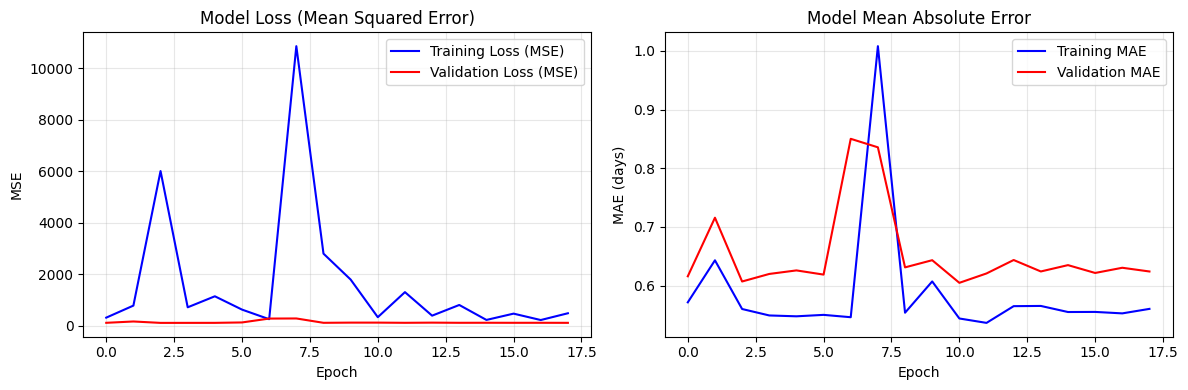

In [33]:
plot_training_history_result = plot_training_history(history=train_model_result)
plot_training_history_result

In [34]:
def plot_predictions_vs_actual(y_actual, y_pred):
    """
    Create visualizations to assess regression model performance.
    
    These plots help understand how well the model predictions align with
    actual ICU length of stay values and identify potential patterns in errors.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatter plot: Predicted vs Actual
    axes[0].scatter(y_actual, y_pred, alpha=0.6, color='blue')
    axes[0].plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 
                 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual ICU Stay (days)')
    axes[0].set_ylabel('Predicted ICU Stay (days)')
    axes[0].set_title('1st 48 Hrs Time Series Predicted vs Actual ICU Length of Stay')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Residuals plot (prediction errors)
    residuals = y_pred - y_actual
    axes[1].scatter(y_pred, residuals, alpha=0.6, color='green')
    axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Predicted ICU Stay (days)')
    axes[1].set_ylabel('Residuals (Predicted - Actual)')
    axes[1].set_title('Residuals Plot')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

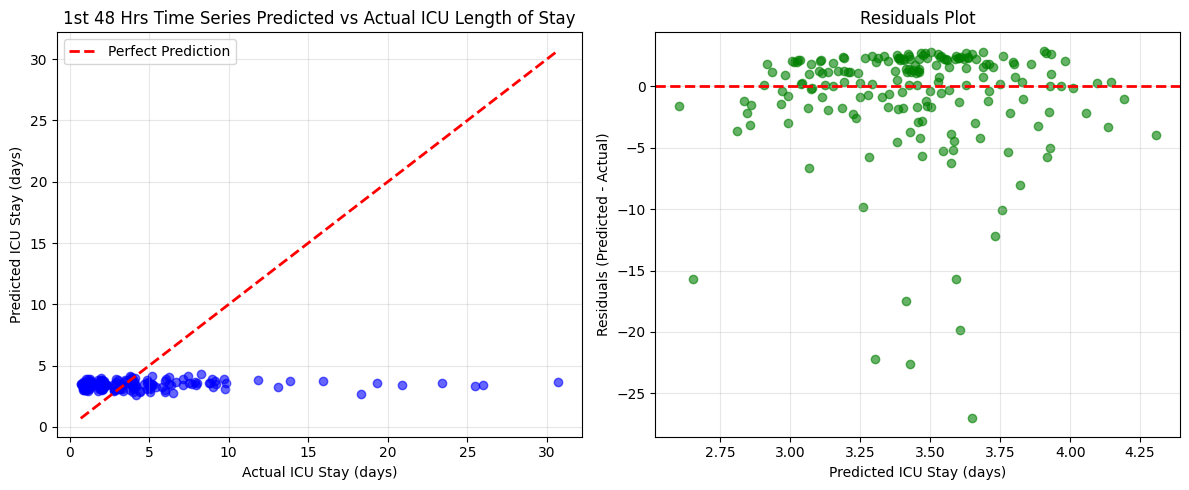

In [35]:
plot_predictions_vs_actual_results = plot_predictions_vs_actual(y_actual=y_test, y_pred=y_pred) 
plot_predictions_vs_actual_results

In [36]:
def plot_ApacheIVa_predictions_vs_actual(y_actual, y_pred):
    """
    Create visualizations to assess regression model performance.
    
    These plots help understand how well the model predictions align with
    actual ICU length of stay values and identify potential patterns in errors.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatter plot: Predicted vs Actual
    axes[0].scatter(y_actual, y_pred, alpha=0.6, color='blue')
    axes[0].plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 
                 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual ICU Stay (days)')
    axes[0].set_ylabel('Predicted ICU Stay (days)')
    axes[0].set_title('1st 48 Hrs Time Series Predicted vs Actual ICU Length of Stay')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Residuals plot (prediction errors)
    residuals = y_pred - y_actual
    axes[1].scatter(y_pred, residuals, alpha=0.6, color='green')
    axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Predicted ICU Stay (days)')
    axes[1].set_ylabel('Residuals (Predicted - Actual)')
    axes[1].set_title('Residuals Plot')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

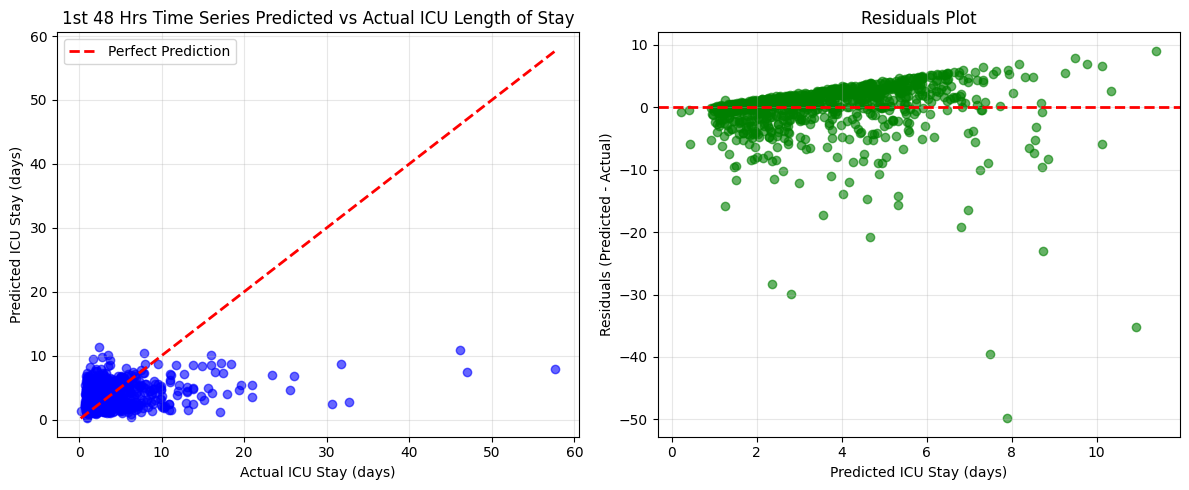

In [37]:
plot_ApacheIVa_predictions_vs_actual_results = plot_ApacheIVa_predictions_vs_actual(y_actual=eICUerd_1st48hrs_st123_CleanedApacheResults_ExitedHospitalAlive['actualiculos'], y_pred=eICUerd_1st48hrs_st123_CleanedApacheResults_ExitedHospitalAlive['predictediculos']) # or y_pred=y_pred)
plot_ApacheIVa_predictions_vs_actual_results